In [48]:
import numpy as np
import pandas as pd 
import matplotlib as mpl
import matplotlib.pyplot as plt


from adv_finance import bars

In [2]:
%load_ext autoreload 
%autoreload 2

In [3]:
plt.style.use('seaborn-talk')
plt.style.use('bmh')
pd.set_option('display.max_rows', 100)


## Load Tick Data 

In [118]:
TRADE_A233740 = pd.read_parquet('/nfs/data/interim/TRADE_A233740.parq').set_index('TIME')


In [127]:
df = TRADE_A233740

In [49]:
dv_bars = bars.dollar_bars(df, 'DV', 1_000_000_000)

100%|██████████| 11946001/11946001 [00:05<00:00, 2341712.33it/s]


In [129]:
%%time
tidx = bars.get_imbalance(df.PRICE.values) * df.DV.iloc[1:]

wndo = tidx.shape[0] // 1000 
print(f"window size: {wndo:,.2f}")

E_bs = tidx.ewm(wndo).mean() 
E_T = pd.Series(range(tidx.shape[0]), index=tidx.index).ewm(wndo).mean()

df0 = (pd.DataFrame()
       .assign(E_T=E_T)
       .assign(E_bs=E_bs)
       .assign(absMul=lambda df: df.E_T * np.abs(df.E_bs))
       .assign(absTheta=tidx.cumsum().abs())       
      )

window size: 11,946.00
CPU times: user 57.3 s, sys: 2.67 s, total: 60 s
Wall time: 59.8 s


In [32]:
df0_1 = df0
df0_1_ts = df0_1.groupby(['TIME'])['E_T'].count()
df0_1_ts = df0_1_ts.rename('ts')
df0_1_j = pd.merge(df0_1, df0_1_ts, left_index=True, right_index=True)


In [78]:
%%time
tm_arr = df0_1_j.index.values
ts_arr = df0_1_j['ts'].values
abs_theta_arr = df0_1_j['absTheta'].values
e_bs_arr = df0_1_j['E_bs'].values

imb_bars = bars.agg_imb_bars(tm_arr, ts_arr, abs_theta_arr, e_bs_arr)


CPU times: user 1.53 s, sys: 1.06 s, total: 2.58 s
Wall time: 2.58 s


In [79]:
test_imb_bars = (pd.DataFrame(imb_bars, columns=['start', 'stop', 'Ts'])
                 .drop_duplicates()
)

In [40]:
%%time
dv_imb_bars = df.PRICE.loc[test_imb_bars.stop].drop_duplicates()

In [67]:
df_imb_bars = df.loc[dv_imb_bars.index]

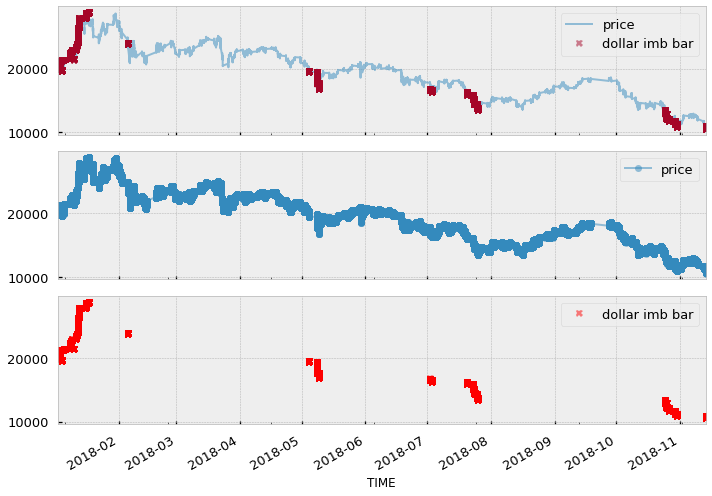

In [71]:
xDate = '2018'
xdf, xtdf = bars.select_sample_data(df, df_imb_bars, 'PRICE', xDate)
bars.plot_sample_data(xdf, xtdf, 'dollar imb bar', alpha=0.5, markersize=7)   


In [73]:
dv_imb_bars.loc['2018-04']

Series([], Name: PRICE, dtype: int32)

In [92]:
imb_bars_stop

DatetimeIndex(['2018-01-02 09:03:06', '2018-01-02 09:04:56',
               '2018-01-02 09:13:44', '2018-01-02 09:20:01',
               '2018-01-02 10:00:03', '2018-01-02 10:00:03',
               '2018-01-02 10:00:04', '2018-01-02 10:00:04',
               '2018-01-02 10:00:05', '2018-01-02 10:00:05',
               ...
               '2018-12-28 15:19:54', '2018-12-28 15:19:54',
               '2018-12-28 15:19:55', '2018-12-28 15:19:55',
               '2018-12-28 15:19:56', '2018-12-28 15:19:56',
               '2018-12-28 15:19:57', '2018-12-28 15:19:57',
               '2018-12-28 15:19:58', '2018-12-28 15:19:59'],
              dtype='datetime64[ns]', name='stop', length=5396956, freq=None)

In [85]:
imb_bars_stop = pd.DatetimeIndex(test_imb_bars.stop)

In [90]:
imb_bars_stop[imb_bars_stop == '2018-04']

DatetimeIndex([], dtype='datetime64[ns]', name='stop', freq=None)

In [ ]:
def returns(s):
    arr = np.diff(np.log(s))
    return (pd.Series(arr, index=s.index[1:]))


dr = returns(dv_bars.PRICE)
dr_imb = returns(dv_imb_bars)

# APPENDIX

In [93]:
# 2018, 3, 4월을 추려보자

In [119]:
df_0102 = TRADE_A233740.loc['2018-01':'2018-02']

In [121]:
df_0304 = TRADE_A233740.loc['2018-03':'2018-04']

In [98]:
df = df_0304

tidx = bars.get_imbalance(df.PRICE.values) * df.DV.iloc[1:]
wndo = tidx.shape[0] // 1000 
print(f"window size: {wndo:,.2f}")

E_bs = tidx.ewm(wndo).mean() 
E_T = pd.Series(range(tidx.shape[0]), index=tidx.index).ewm(wndo).mean()

df0 = (pd.DataFrame()
       .assign(E_T=E_T)
       .assign(E_bs=E_bs)
       .assign(absMul=lambda df: df.E_T * np.abs(df.E_bs))
       .assign(absTheta=tidx.cumsum().abs())       
      )

window size: 1,754.00


In [101]:
df0_1 = df0[:10000]
df0_1_ts = df0_1.groupby(['TIME'])['E_T'].count()
df0_1_ts = df0_1_ts.rename('ts')
df0_1_j = pd.merge(df0_1, df0_1_ts, left_index=True, right_index=True)

In [104]:
%%time
tm_arr = df0_1_j.index.values
ts_arr = df0_1_j['ts'].values
abs_theta_arr = df0_1_j['absTheta'].values
e_bs_arr = df0_1_j['E_bs'].values

imb_bars0 = bars.agg_imb_bars(tm_arr, ts_arr, abs_theta_arr, e_bs_arr)

CPU times: user 1.61 s, sys: 126 ms, total: 1.74 s
Wall time: 1.73 s


In [108]:
%%time
imb_bars1 = bars.agg_imbalance_bars_(df0_1_j)

CPU times: user 4.79 s, sys: 0 ns, total: 4.79 s
Wall time: 4.79 s


In [111]:
imb_bars0[:10]

[(numpy.datetime64('2018-03-02T09:00:28.000000000'),
  numpy.datetime64('2018-03-02T09:00:28.000000000'),
  55),
 (numpy.datetime64('2018-03-02T09:00:28.000000000'),
  numpy.datetime64('2018-03-02T09:00:28.000000000'),
  55),
 (numpy.datetime64('2018-03-02T09:00:28.000000000'),
  numpy.datetime64('2018-03-02T09:00:29.000000000'),
  68),
 (numpy.datetime64('2018-03-02T09:00:29.000000000'),
  numpy.datetime64('2018-03-02T09:00:30.000000000'),
  22),
 (numpy.datetime64('2018-03-02T09:00:30.000000000'),
  numpy.datetime64('2018-03-02T09:00:30.000000000'),
  9),
 (numpy.datetime64('2018-03-02T09:00:30.000000000'),
  numpy.datetime64('2018-03-02T09:00:30.000000000'),
  9),
 (numpy.datetime64('2018-03-02T09:00:30.000000000'),
  numpy.datetime64('2018-03-02T09:00:30.000000000'),
  9),
 (numpy.datetime64('2018-03-02T09:00:30.000000000'),
  numpy.datetime64('2018-03-02T09:00:30.000000000'),
  9),
 (numpy.datetime64('2018-03-02T09:00:30.000000000'),
  numpy.datetime64('2018-03-02T09:00:30.0000000

In [112]:
imb_bars1[:10]

[(Timestamp('2018-03-02 09:00:28'), Timestamp('2018-03-02 09:00:28'), 55),
 (Timestamp('2018-03-02 09:00:28'), Timestamp('2018-03-02 09:00:28'), 55),
 (Timestamp('2018-03-02 09:00:28'), Timestamp('2018-03-02 09:00:29'), 68),
 (Timestamp('2018-03-02 09:00:29'), Timestamp('2018-03-02 09:00:30'), 22),
 (Timestamp('2018-03-02 09:00:30'), Timestamp('2018-03-02 09:00:30'), 9),
 (Timestamp('2018-03-02 09:00:30'), Timestamp('2018-03-02 09:00:30'), 9),
 (Timestamp('2018-03-02 09:00:30'), Timestamp('2018-03-02 09:00:30'), 9),
 (Timestamp('2018-03-02 09:00:30'), Timestamp('2018-03-02 09:00:30'), 9),
 (Timestamp('2018-03-02 09:00:30'), Timestamp('2018-03-02 09:00:30'), 9),
 (Timestamp('2018-03-02 09:00:30'), Timestamp('2018-03-02 09:00:30'), 9)]

In [114]:
# 검증 
t0 = imb_bars0
b0 = imb_bars1

bars_start = [b[0] for b in bars]
bars_end = [b[1] for b in bars]
bars_start= pd.DatetimeIndex(bars_start).astype('int')
bars_end = pd.DatetimeIndex(bars_end).astype('int')
bars_ts = [b[2] for b in bars]

test_start = [t[0].astype('int') for t in test_bars]
test_end = [t[1].astype('int') for t in test_bars]
test_ts = [t[2] for t in test_bars]

for t, i in enumerate(zip(bars_start, bars_end, bars_ts, test_start, test_end, test_ts)): 
    if i[0] != i[3] or i[1] != i[4] or i[2] != i[5]: 
        print(f"t={t}, bar = ({(i[0], i[1], i[2])}), test = ({(i[3], i[4], i[5])}),")


TypeError: 'module' object is not iterable